# Lab 2: Cats vs Dogs

**Deadline**: Feb 01, 5:00pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**Marking TA**: Tinglin (Francis) Duan

This lab is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/11fmZwB9E_jdLVS-UP23Wd4_9Y83qOlRz?usp=sharing

In [2]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [3]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [4]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

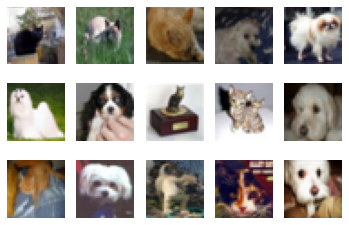

In [5]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [6]:
print("Training Examples =", len(train_loader))
print("Validation Examples =", len(val_loader))
print("Test Examples =", len(test_loader))

Training Examples = 8000
Validation Examples = 2000
Test Examples = 2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

We need validation set when training our model to avoid overfitting. We can use the validation set to tune the higher level hyperparameters. The model directly learns from a training set, whereas the model is indirectly learning from the validation set by the user changing the hyperparameters. If we judge the performance of our models using the training set loss/error instead of validation set loss/error, we could be overfitting our data.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [7]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [8]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [9]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [10]:
for param in small_net.parameters():
    print(param.shape)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])


In [11]:
for param in small_net.parameters():
    print(param.shape.numel())

135
5
245
1


Total number of parameters in small_net = 386

In [12]:
for param in large_net.parameters():
    print(param.shape)

torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


In [13]:
for param in large_net.parameters():
    print(param.shape.numel())

375
5
1250
10
8000
32
32
1


Total number of parameters in large_net = 9705

### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [14]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

Default value batch_size: 64

Default value learning_rate: 0.01

Default value num_epochs: 30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

model_small_bs64_lr0.01_epoch0

model_small_bs64_lr0.01_epoch1

model_small_bs64_lr0.01_epoch2

model_small_bs64_lr0.01_epoch3

model_small_bs64_lr0.01_epoch4

model_small_bs64_lr0.01_epoch4_train_err.csv (training set error for epoch 4(5))

model_small_bs64_lr0.01_epoch4_train_loss.csv (training set loss for epoch 4(5))

model_small_bs64_lr0.01_epoch4_val_err.csv (validation set error for epoch 4(5))

model_small_bs64_lr0.01_epoch4_val_loss.csv (validation set loss for epoch 4(5))

In [15]:
train_net(small_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.427625, Train loss: 0.6741959056854248 |Validation err: 0.3775, Validation loss: 0.6597265005111694
Epoch 2: Train err: 0.365125, Train loss: 0.6430219621658325 |Validation err: 0.3705, Validation loss: 0.6553609501570463
Epoch 3: Train err: 0.347, Train loss: 0.6270276293754578 |Validation err: 0.348, Validation loss: 0.6260313391685486
Epoch 4: Train err: 0.333625, Train loss: 0.6116100740432739 |Validation err: 0.3565, Validation loss: 0.6285025924444199
Epoch 5: Train err: 0.32075, Train loss: 0.6046628150939941 |Validation err: 0.3395, Validation loss: 0.6177340876311064
Epoch 6: Train err: 0.3145, Train loss: 0.5928595442771911 |Validation err: 0.3355, Validation loss: 0.6153966169804335
Epoch 7: Train err: 0.310625, Train loss: 0.5870834405422211 |Validation err: 0.3285, Validation loss: 0.6046376973390579
Epoch 8: Train err: 0.303625, Train loss: 0.5786808829307556 |Validation err:

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [16]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [17]:
train_net(small_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.27, Train loss: 0.53282723402977 |Validation err: 0.295, Validation loss: 0.5743504017591476
Epoch 2: Train err: 0.269625, Train loss: 0.5335272345542907 |Validation err: 0.297, Validation loss: 0.5843025427311659
Epoch 3: Train err: 0.267, Train loss: 0.5322322626113891 |Validation err: 0.293, Validation loss: 0.5706519680097699
Epoch 4: Train err: 0.267125, Train loss: 0.5336958305835724 |Validation err: 0.2915, Validation loss: 0.5748661998659372
Epoch 5: Train err: 0.265375, Train loss: 0.5314749937057495 |Validation err: 0.2855, Validation loss: 0.5670599397271872
Epoch 6: Train err: 0.2675, Train loss: 0.5314255261421204 |Validation err: 0.2975, Validation loss: 0.5833839969709516
Epoch 7: Train err: 0.26975, Train loss: 0.5325355689525604 |Validation err: 0.292, Validation loss: 0.5673605212941766
Epoch 8: Train err: 0.263, Train loss: 0.5310534467697143 |Validation err: 0.2805, Val

In [18]:
large_net = LargeNet()
train_net(large_net, 64, 0.01, 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.44475, Train loss: 0.6900203123092651 |Validation err: 0.4285, Validation loss: 0.6807542946189642
Epoch 2: Train err: 0.4195, Train loss: 0.67819615650177 |Validation err: 0.413, Validation loss: 0.6741204150021076
Epoch 3: Train err: 0.39875, Train loss: 0.6658886175155639 |Validation err: 0.3925, Validation loss: 0.6518177818506956
Epoch 4: Train err: 0.373875, Train loss: 0.6490470728874207 |Validation err: 0.406, Validation loss: 0.6635930277407169
Epoch 5: Train err: 0.35375, Train loss: 0.6330237889289856 |Validation err: 0.353, Validation loss: 0.6284337677061558
Epoch 6: Train err: 0.339125, Train loss: 0.6160062110424042 |Validation err: 0.34, Validation loss: 0.6150468923151493
Epoch 7: Train err: 0.32625, Train loss: 0.6001663441658021 |Validation err: 0.335, Validation loss: 0.6086486000567675
Epoch 8: Train err: 0.313875, Train loss: 0.5828366029262543 |Validation err: 0.3325

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

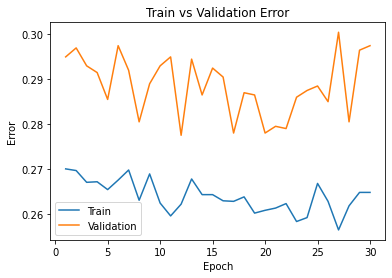

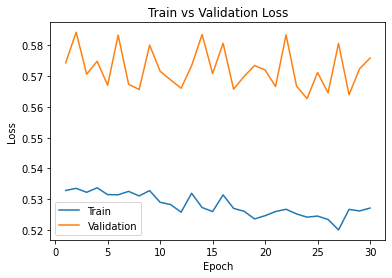

In [19]:
plot_training_curve(get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29))

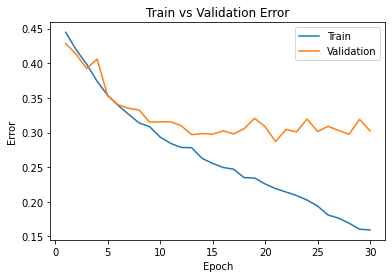

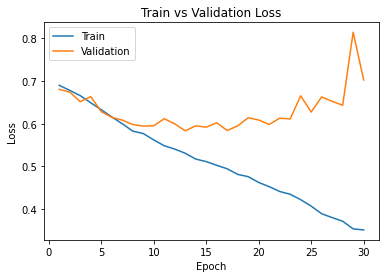

In [20]:
plot_training_curve(get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29))

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

The training curve for small_net is somewhat stable (oscillates up and down) as the number of epoch increases, whereas the training curve for large_net is continuously decreasing as the number of epoch increses.

The small_net seems to be overfitting because the error on the training set is low, but the error on the validation set is large.

The large_net seems to be underfitting at lower number of epochs because both the error on the training set and the validation set is high. As the number of epoch increases, large_net seems to be overfitting because the error on the training set is low, whereas the error on the validation set is large.


## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

In [21]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, 64, 0.001, 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360013961792 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589712142945 |Validation err: 0.4305, Validation loss: 0.691649341955781
Epoch 3: Train err: 0.43575, Train loss: 0.6916067280769348 |Validation err: 0.4285, Validation loss: 0.690854424610734
Epoch 4: Train err: 0.43, Train loss: 0.690861343383789 |Validation err: 0.424, Validation loss: 0.6896595880389214
Epoch 5: Train err: 0.434125, Train loss: 0.6899195008277893 |Validation err: 0.4195, Validation loss: 0.6886935643851757
Epoch 6: Train err: 0.43575, Train loss: 0.6887411961555481 |Validation err: 0.4195, Validation loss: 0.6867824867367744
Epoch 7: Train err: 0.437125, Train loss: 0.6873774147033691 |Validation err: 0.4185, Validation loss: 0.6851982977241278
Epoch 8: Train err: 0.4375, Train loss: 0.6859278454780579 |Validation err: 0.412,

Originally, with the learning_rate = 0.01, the large_net model took 120.32 seconds to train.

Now, with the learning rate = 0.001, the large_net model takes 121.63 seconds to train.

Thus, the model takes longer time to train with a smaller learning rate (lr = 0.001).

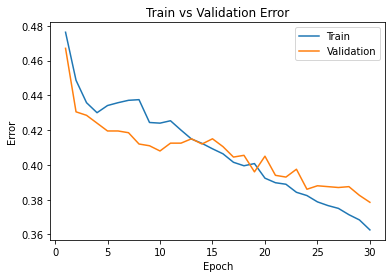

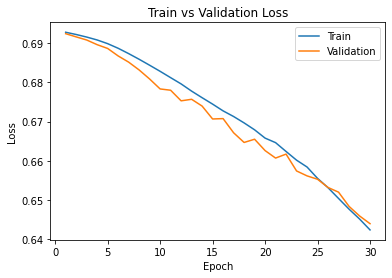

In [22]:
plot_training_curve(get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29))

As the learning rate was lowered, there is less overfitting because the error on the training set is not as low compared to the error on the validation set. 

Before, the model showed overfitting when the number of epoch increased because the error on the training set was low while the error on the validation set was large. 

However, as the learning rate was lowered, it seems that the error has increased for both the training set and the validation set. Also, as the learning rate was lowered, it seems that the loss has increased for training set, but has decreased for the validation set.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

In [23]:
large_net = LargeNet()
train_net(large_net, 64, 0.1, 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.67437779712677 |Validation err: 0.3595, Validation loss: 0.6350857093930244
Epoch 2: Train err: 0.36075, Train loss: 0.6411805458068848 |Validation err: 0.3535, Validation loss: 0.6361209936439991
Epoch 3: Train err: 0.365125, Train loss: 0.6321813461780548 |Validation err: 0.3385, Validation loss: 0.6056603882461786
Epoch 4: Train err: 0.352625, Train loss: 0.6233456182479858 |Validation err: 0.3575, Validation loss: 0.6362800188362598
Epoch 5: Train err: 0.34075, Train loss: 0.6108013873100281 |Validation err: 0.3305, Validation loss: 0.6064918786287308
Epoch 6: Train err: 0.323375, Train loss: 0.5921835997104645 |Validation err: 0.317, Validation loss: 0.5967769594863057
Epoch 7: Train err: 0.3145, Train loss: 0.5817317583560944 |Validation err: 0.3365, Validation loss: 0.6204487886279821
Epoch 8: Train err: 0.29825, Train loss: 0.5660300073623658 |Validation err: 0.

Originally, with the learning_rate = 0.01, the large_net model took 120.32 seconds to train.

Now, with the learning rate = 0.1, the large_net model takes 119.16 seconds to train.

Thus, the model takes shorter time to train with a larger learning rate (lr = 0.1).

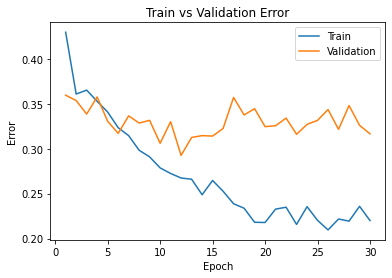

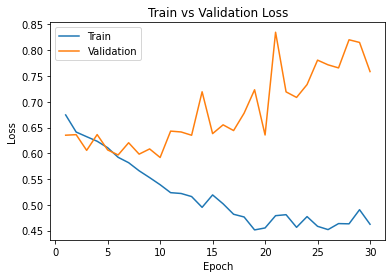

In [24]:
plot_training_curve(get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29))

As the learning rate was increased, there is more overfitting because the error on the training set is lower compared to the error on the validation set. 

Before, the model showed overfitting when the number of epoch increased because the error on the training set was low while the error on the validation set was large. Now, there is more difference in the training set and validation set.

Also, there seems to be more noise when the learning rate was increased.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

In [25]:
large_net = LargeNet()
train_net(large_net, 512, 0.01, 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500590741634 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449940383434 |Validation err: 0.424, Validation loss: 0.6897870451211929
Epoch 5: Train err: 0.434, Train loss: 0.6896935552358627 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.688353206962347 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871677339077 |Validation err: 0.426, Validation loss: 0.6836968809366226
Epoch 8: Train err: 0.43525, Train loss: 0.6849770769476891 |Validation err: 0.4115, Va

Originally, with the batch_size = 64, the large_net model took 120.32 seconds to train.

Now, with the batch_size = 512, the large_net model takes 103.43 seconds to train.

Thus, the model takes shorter time to train with a larger batch_size (batch_size = 512).

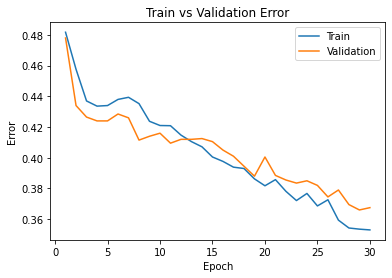

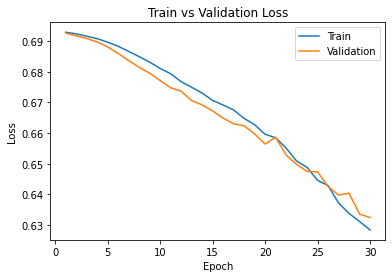

In [26]:
plot_training_curve(get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29))

As the batch size was increased, there is less overfitting because the error on the training set is not as low compared to the error on the validation set. 

Before, the model showed overfitting when the number of epoch increased because the error on the training set was low while the error on the validation set was large. 

However, as the batch size was increased, it seems that the error has increased for both the training set and the validation set. Also, as the batch size was increased, it seems that the loss has increased for training set, but has decreased for the validation set.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

In [27]:
large_net = LargeNet()
train_net(large_net, 16, 0.01, 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774994022846222 |Validation err: 0.382, Validation loss: 0.6513170118331909
Epoch 2: Train err: 0.369, Train loss: 0.639639899969101 |Validation err: 0.3465, Validation loss: 0.6161113576889038
Epoch 3: Train err: 0.34375, Train loss: 0.6098222947120666 |Validation err: 0.3325, Validation loss: 0.6260210764408112
Epoch 4: Train err: 0.314375, Train loss: 0.5849691489338875 |Validation err: 0.34, Validation loss: 0.6044013917446136
Epoch 5: Train err: 0.301125, Train loss: 0.5689119303822517 |Validation err: 0.3125, Validation loss: 0.576918310880661
Epoch 6: Train err: 0.281, Train loss: 0.5452213581204415 |Validation err: 0.308, Validation loss: 0.5708447456359863
Epoch 7: Train err: 0.270875, Train loss: 0.5272981298565864 |Validation err: 0.307, Validation loss: 0.5854293291568756
Epoch 8: Train err: 0.259375, Train loss: 0.5070905526578426 |Validation err: 0.313, 

Originally, with the batch_size = 64, the large_net model took 120.32 seconds to train.

Now, with the batch_size = 16, the large_net model takes 182.18 seconds to train.

Thus, the model takes longer time to train with a smaller batch_size (batch_size = 16).

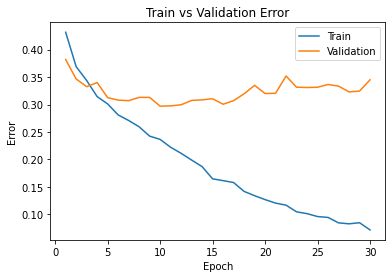

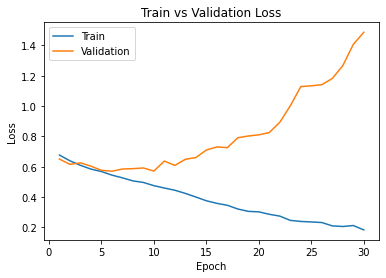

In [28]:
plot_training_curve(get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29))

As the batch size was decreased, there is more overfitting because the error on the training set is lower compared to the error on the validation set. 

Before, the model showed overfitting when the number of epoch increased because the error on the training set was low while the error on the validation set was large. Now, there is more difference in the training set and validation set.

Also, there seems to be less noise when the batch size was decreased.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

Large_net, batch_size = 16, learning_rate = 0.001.

Becuase changing the learning_rate to 0.001 reduced the overfitting of the sets but the overall error increased for the validation, whereas changing the batch_size to 16 increased the overfitting, but decreased the overall error for the validation. Thus together, there was less overfitting and less validation error, improving the validation accuracy.

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.454875, Train loss: 0.6919687836170196 |Validation err: 0.4335, Validation loss: 0.6896940703392029
Epoch 2: Train err: 0.441875, Train loss: 0.6881972500085831 |Validation err: 0.4155, Validation loss: 0.6840243172645569
Epoch 3: Train err: 0.425, Train loss: 0.6826031126976013 |Validation err: 0.4065, Validation loss: 0.6759178109169006
Epoch 4: Train err: 0.413375, Train loss: 0.676551971077919 |Validation err: 0.411, Validation loss: 0.6703446621894836
Epoch 5: Train err: 0.403, Train loss: 0.6706955729722976 |Validation err: 0.405, Validation loss: 0.6636172285079956
Epoch 6: Train err: 0.388375, Train loss: 0.6634951171875 |Validation err: 0.388, Validation loss: 0.6577684187889099
Epoch 7: Train err: 0.38325, Train loss: 0.6566604214906693 |Validation err: 0.387, Validation loss: 0.6490317993164062
Epoch 8: Train err: 0.372625, Train loss: 0.6456744936108589 |Validation err: 0.3795,

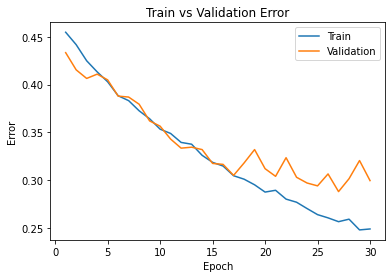

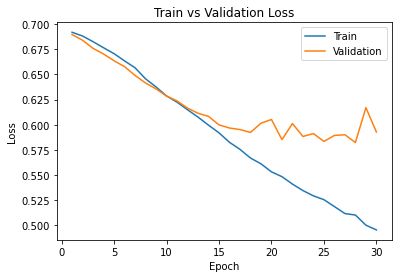

In [29]:
large_net = LargeNet()
train_net(large_net, 16, 0.001, 30)

plot_training_curve(get_model_name("large", batch_size=16, learning_rate=0.001, epoch=29))

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

Large_net, batch_size = 512, learning_rate = 0.1.

Becuase changing the batch_size to 512 reduced the overfitting of the sets but the overall error increased for the validation, whereas changing the learning_rate to 0.1 increased the overfitting, but decreased the overall error for the validation. Thus together, there was less overfitting and less validation error, improving the validation accuracy.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.477875, Train loss: 0.6929536536335945 |Validation err: 0.476, Validation loss: 0.687719076871872
Epoch 2: Train err: 0.44975, Train loss: 0.6866156831383705 |Validation err: 0.4355, Validation loss: 0.6788475513458252
Epoch 3: Train err: 0.417375, Train loss: 0.677769310772419 |Validation err: 0.406, Validation loss: 0.6653236448764801
Epoch 4: Train err: 0.402, Train loss: 0.6664926782250404 |Validation err: 0.3945, Validation loss: 0.658050611615181
Epoch 5: Train err: 0.3855, Train loss: 0.6551658473908901 |Validation err: 0.3675, Validation loss: 0.6423593163490295
Epoch 6: Train err: 0.365, Train loss: 0.6404123604297638 |Validation err: 0.364, Validation loss: 0.6320077627897263
Epoch 7: Train err: 0.356375, Train loss: 0.6332094147801399 |Validation err: 0.335, Validation loss: 0.6137653887271881
Epoch 8: Train err: 0.339625, Train loss: 0.6179096810519695 |Validation err: 0.3465, 

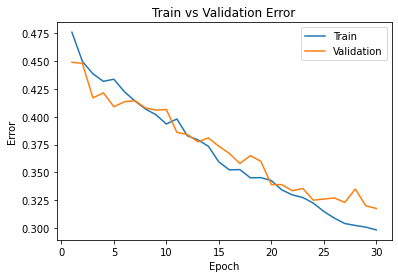

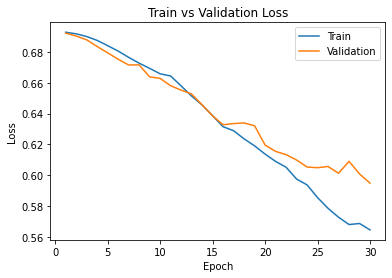

In [33]:
large_net = LargeNet()
train_net(large_net, 512, 0.1, 30)

plot_training_curve(get_model_name("large", batch_size=512, learning_rate=0.1, epoch=29))

## Part 5. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [34]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=16, learning_rate=0.001, epoch=27)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

Large_net, batch_size = 16, learning_rate = 0.001, epoch = 27.

Becuase changing the learning_rate to 0.001 reduced the overfitting of the sets but the overall error increased for the validation, whereas changing the batch_size to 16 increased the overfitting, but decreased the overall error for the validation. Thus together, there was less overfitting and less validation error, improving the validation accuracy.

At Epoch = 27, there is the lowest validation error of 0.288.

In conclusion, I chose this model because it does not have overfitting, and the error decreased to 0.288 at the lowest, which both implies good validation accuracy.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [40]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64)

evaluate(net, test_loader, nn.BCEWithLogitsLoss())

Files already downloaded and verified
Files already downloaded and verified


(0.2855, 0.5526062799617648)

Test Classification Error is 0.2855.

### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [41]:
evaluate(net, val_loader, nn.BCEWithLogitsLoss())

(0.3015, 0.58578981179744)

I would expect the test error to be higher than validation error because the best model for validation was chosen by adjusting hyperparameters, whereas the test model was not known for us to adjust to it. However, my test error was lower than validation error.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

We only used the test data set at the very end to test the model that we have already trained. It is important to use as little test data as possible because it is uesd only to verifying the results, whereas the other training data and validation data is used to train and adjust the hyperparameters of the model.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [44]:
class Cat_Dog(nn.Module):
    def __init__(self):
        super(Cat_Dog, self).__init__()
        self.name = "CatDog"
        self.layer1 = nn.Linear(3 * 32 * 32, 30)
        self.layer2 = nn.Linear(30, 1)
        #self.layer3 = nn.Linear(1500, 1)
    def forward(self, img):
        flattened = img.view(-1, 3 * 32 * 32)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        
        activation2 = self.layer2(activation1)
        #activation2 = F.relu(activation2)
        
        #activation3 = self.layer3(activation2)
        return activation2.squeeze()

cats_dogs = Cat_Dog()

train_net(cats_dogs, 16, 0.001, 27)


train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64)

test_error, test_loss = evaluate(cats_dogs, test_loader, nn.BCEWithLogitsLoss())

print("Test err: ", test_error)
print("Test loss: ", test_loss)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.413375, Train loss: 0.6650850504040718 |Validation err: 0.3925, Validation loss: 0.6526617212295532
Epoch 2: Train err: 0.37525, Train loss: 0.6436380042433739 |Validation err: 0.392, Validation loss: 0.6516472935676575
Epoch 3: Train err: 0.3665, Train loss: 0.6341393489837647 |Validation err: 0.382, Validation loss: 0.645181411743164
Epoch 4: Train err: 0.34975, Train loss: 0.6240796703100204 |Validation err: 0.3945, Validation loss: 0.6618771114349365
Epoch 5: Train err: 0.342, Train loss: 0.6170741337537765 |Validation err: 0.378, Validation loss: 0.6427467465400696
Epoch 6: Train err: 0.329875, Train loss: 0.60537016248703 |Validation err: 0.3945, Validation loss: 0.6619392056465149
Epoch 7: Train err: 0.318125, Train loss: 0.596566174030304 |Validation err: 0.375, Validation loss: 0.6482871866226196
Epoch 8: Train err: 0.314125, Train loss: 0.5859173473119735 |Validation err: 0.3765,